## Introduction

In this notebook, we will build a model to predict if a molecule inhibits HIV replication using the [ogbg-molhiv](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) dataset.  This is derived from the [MoleculeNet](https://moleculenet.org/) dataset and represents each molecule as a graph, where the nodes are atoms and the edges are chemical bonds.  We will treat this as a graph classification task and use a modified version of the [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826) (GIN). Once we create this benchmark, we will add the idea of a [Virtual Node](https://arxiv.org/abs/1704.01212). 

## What you need to do
### Basics

In this task we're going to apply a GNN to the molecular structure to get node embeddings for each atom and then apply a "Readout" function to combine those node embeddings into a representation of the graph.  Instead of having batches of nodes like previous exercises, this time we'll be dealing with batches of small graphs.  This difference will result in some additional implementation complexity.  Sections you need to write code for will be marked with a "TODO" comment. For ease of troubleshooting, do not modify any of the code except where indicated until after the basics have been achieved.  We will also import functionality from the `utils.py` script.  No changes should be necessary to this file.

### Improvements

Once you have a correct implementation and can match leaderboard performance, we can move on to experimentation. In this section, we will implement "Virtual Nodes", which are nodes added to each graph that connect to all other nodes and therefore provide a short communication path between all nodes in a graph.

### Statistics

In each section, the `repeat_experiments` function is used to run the same model building process multiple times to collect statistics since there is significant variation in performance from run-to-run.  This allows us to make apples-to-apples comparisons to the leaderboard, but this process takes a long time.  Feel free to reduce from the default setup of 10 experiments with 100 epochs each to something much smaller (e.g., 1 experiment with 5 epochs) until you're confident in the implementation.


### Extra Credit

A great way to learn is to 1) read other peoples' code and 2) tinker. If you want to maximize your learning, the Extra Credit section will provide a few directions for further exploration. As part of this, it's recommended you find another submission on the OGB Leaderboard and try to re-create its submission. This will likely involve reading the paper and code, which is great practice. If you do something interesting and novel, we'll kindly host it in a public repo as an example of your glory (if you wish).


# Boilerplate

In [1]:
import os, sys
import math
from copy import deepcopy
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 1.7.1.  CUDA version: 10.1


In [3]:
# Follow instructions at https://www.dgl.ai/pages/start.html
!{sys.executable} -m pip install dgl-cu101 -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [4]:
!{sys.executable} -m pip install ogb

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler

import dgl.function as fn

from ogb.graphproppred import DglGraphPropPredDataset, Evaluator
from ogb.graphproppred.mol_encoder import BondEncoder, AtomEncoder

Using backend: pytorch


In [6]:
dgl.__version__

'0.7.2'

In [7]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
device = th.device(device)
device

device(type='cuda')

## Helper functions

In [8]:
%load_ext autoreload
%autoreload 2

In [10]:
from utils import repeat_experiments, norm_plot, train, test

## Capture GIN leaderboard performance

In [224]:
# Values from the OGB leaderboard of GIN, submitted May 01, 2020
val_auc_lb, val_auc_lb_std, test_auc_lb, test_auc_lb_std = 0.8232, 0.0090, 0.7558, 0.0140
evaluator = Evaluator(name = "ogbg-molhiv")

# Data 

This dataset consists of 41k molecule graphs with an average of 25.5 nodes and 27.5 edges per graph.  The nodes and edges both have natural features like atomic number, bond type...etc (full list [here](https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/utils/features.py#L2-L35)).  The binary target variable encodes whether or not the molecule inhibits HIV replication and we therefore treat this as a binary classification task and evaluate with ROC AUC.  The graphs are split using a...

> _scaffold splitting_ procedure that splits the molecules based on their two-dimensional structural frameworks. The scaffold splitting attempts to separate structurally different molecules into different subsets, which provides a more realistic estimate of model performance in prospective experimental settings

More details on the dataset can be found on the [OGB dataset page](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol).

## Create DGL dataset using OGB
We will use the `ogb` python package to download the data, give us the correct train/validation/test splits for proper comparison and an `Evaluator` to make sure performance is measured appropriately.  To properly handle the batching of graphs with their labels, we create a wrapper around the OGB dataset, according to process explained [here](https://docs.dgl.ai/tutorials/blitz/6_load_data.html#creating-a-dataset-for-graph-classification-from-csv).  In essence, we need an object that returns both the graph and the label.

In [12]:
class MolHIVDataset(DGLDataset):
    """
    A wrapper around the OGB dataset so that the label is returned along 
    with the graph, as specified in __getitem__.
    See:  https://docs.dgl.ai/tutorials/blitz/6_load_data.html#creating-a-dataset-for-graph-classification-from-csv
    """
    def __init__(self):
        super().__init__(name='ogbg-molhiv')
        
    def _load(self):
        self.dataset = DglGraphPropPredDataset(name="ogbg-molhiv", root = 'dataset/')
        self.split_idx = self.dataset.get_idx_split()
        print(self.dataset.meta_info)
        
    def __getitem__(self, i):
        return self.dataset.graphs[i], self.dataset.labels[i]

    def __len__(self):
        return len(self.dataset.graphs)

In [13]:
dataset = MolHIVDataset()
assert len(dataset) == 41127

num tasks                                                                1
eval metric                                                         rocauc
download_name                                                          hiv
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/graphproppre...
add_inverse_edge                                                      True
data type                                                              mol
has_node_attr                                                         True
has_edge_attr                                                         True
task type                                            binary classification
num classes                                                              2
split                                                             scaffold
additional node files                                                 None
additional edge files    

### Data loading with batches of graphs

For efficiency reasons, the graphs in a minibatch are combined into one "super-graph" in which each component graph is disconnected from the others.  This enables us to do message passing across all the graphs in the minibatch simultaneously, but comes with the added complexity of needing to keep track of which nodes belong to which graph.  DGL has built-in tools for dealing with this complexity and we'll make use of them throughout this exercise.  Please review the dataloader code in the following cells if you want to see how this works.  Just keep in mind two things: 1) the graph we're passing into the models is the "super-graph" which has all the component graphs in the minibatch combined into one data structure and 2) we'll have to unwind this process when converting from node-level to graph-level representations.

### Create train/val/test dataloaders
See: https://docs.dgl.ai/tutorials/blitz/5_graph_classification.html

In [ ]:
split_idx = dataset.split_idx

In [15]:
train_sampler = SubsetRandomSampler(split_idx['train'])
val_subset = Subset(dataset, split_idx['valid'])
test_subset = Subset(dataset, split_idx['test'])

In [16]:
bs = 32
train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=bs, drop_last=False)
val_dataloader = GraphDataLoader(
    val_subset, shuffle=False, batch_size=bs, drop_last=False)
test_dataloader = GraphDataLoader(
    test_subset, shuffle=False, batch_size=bs, drop_last=False)

In [17]:
len(val_subset), len(test_subset)

(4113, 4113)

In [255]:
it = iter(train_dataloader)
batch = next(it)

The batch returned from the dataloader contains two elements: 

1. A single "super-graph" with all the graphs in the minibatch combined
2. A tensor of labels for each graph

In [256]:
batch

[Graph(num_nodes=726, num_edges=1554,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]])]

Calling `dgl.unbatch` on the single graph will break it into a list of its original component graphs

In [257]:
dgl.unbatch(batch[0])

[Graph(num_nodes=25, num_edges=54,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=21, num_edges=46,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=27, num_edges=52,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=22, num_edges=48,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=22, num_edges=48,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=25, num_edges=56,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes=

### Node and Edge Features
In this case the natural features for both nodes and edges are categorical in nature and the feature data has been encoded into a tensor of integers such that an integer in a column maps to some categorical value (e.g., `bond_type = ['single', 'double', 'triple'] -> [0, 1, 2]`).  These node and edge features are assigned to the graph structure and accessible via `g.ndata['feat']` and `g.edata['feat']`, respectively.  

In [261]:
batch[0].ndata['feat']

tensor([[ 7,  0,  1,  ...,  1,  0,  0],
        [ 5,  0,  3,  ...,  1,  0,  0],
        [ 5,  0,  4,  ...,  2,  0,  0],
        ...,
        [ 5,  0,  3,  ...,  1,  1,  1],
        [ 5,  0,  3,  ...,  1,  1,  1],
        [16,  0,  1,  ...,  2,  0,  0]])

In [262]:
batch[0].edata['feat']

tensor([[1, 0, 1],
        [1, 0, 1],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [3, 0, 1],
        [3, 0, 1]])

OGB provides two built-in classes for converting these integer encodings into float values via the use of lookup embedding layers:  [AtomEncoder](https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/graphproppred/mol_encoder.py#L7) and [BondEncoder](https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/graphproppred/mol_encoder.py#L27).  These classes essentially create an embedding lookup table *for each column* in the feature tensor, and then the integer value in a column serves as the row index in the lookup.  The size of each category embedding is specified with the `emb_dim` variable and therefore the number of learnable embedding parameters for a column in the feature tensor is `N_unique * emb_dim`, where $N_{unique}$ is the number of unique categories in the column.  

Since a single node/edge has multiple categorical features, this process results in an embedding of size `emb_dim` for each categorical feature.  This is reduced to a single embedding of length `emb_dim` by summing these column embeddings together for a final representation of the atom or bond.  For example, if there are three categorical feature columns and we specify `emb_dim=5`, each feature will receive a 5-dim embedding, and then those three vectors will be summed to give a single 5-dim vector as a final representation.  This method is used for both the atom node features and the bond edge features.  

In [21]:
emb_dim = 300

# Modeling 

In graph classification we typically use GNNs to calculate node embeddings and then combine those node embeddings in some way to get a representation of the graph.  This can be tricky when dealing with batches of graphs for training because we need to keep track of which nodes/edges belongs to which graph.  We therefore break our model into 3 main components: 1) the base convolution layer that implements the GIN update equation, 2) the node-level GNN that stacks GIN layers together to create node embeddings and 3) a graph-level GNN that combines node embeddings to create a graph embedding. 

## Graph Isomorphic Network layer

First we will implement the GIN convolution layer.  The GIN model comes from the [How Powerful are Graph Neural Networks](https://arxiv.org/abs/1810.00826) paper.  The equation to update the embedding $\mathbf{h}_i$ for node $i$ is given as:

$$\mathbf{h}_i^{(l+1)} = \text{MLP}[ (1 + \epsilon) \cdot \mathbf{h}_i^{(l)} + \sum_{j \in \mathcal{N}_i} \mathbf{h}_j^{(l)} ]$$

where $\epsilon$ is some learnable constant and $\mathcal{N}_i$ indicates the 1-hop neighborhood of node $i$.  Effectively, it's the sum of the current embedding (adjusted by some scaling factor) added to the embeddings of all its neighbors, passed through an MLP.  

We need to slightly modify this architecture to make use of the edge features, however.  We will use the method implemented on the Leaderboard ([code](https://github.com/snap-stanford/ogb/blob/master/examples/graphproppred/mol/conv.py#L31)), which tweaks the message function to add the edge features to the neighbor node embedding, and pass that sum through a ReLU activation.  In the original equation, the message function merely copies the neighbor embedding: $\mathbf{m}_{ij} = \mathbf{h}_j$.  Here, the message function will be modified to be: $\mathbf{m}_{ij} = \text{ReLU}(\mathbf{h}_j + \mathbf{e}_{ij})$.  The final update equation will therefore become:

$$\mathbf{h}_i^{(l+1)} = \text{MLP}[ (1 + \epsilon) \cdot \mathbf{h}_i^{(l)} + \sum_{j \in \mathcal{N}_i} \text{ReLU}(\mathbf{h}_j^{(l)} + \mathbf{e}_{ij}) ]$$

This causes a slight implementation complication.  The easiest way to use DGL's message passing API is to pass in standard message and reduce functions to the `update_all` method.  For example, the message passing part of the original GIN equation ($\sum_{j \in \mathcal{N}_i} \mathbf{h}_j $) would be implemented like:  `g.update_all(fn.copy_u('x', 'm'), fn.sum('m', h')`.  Using these built-in message/reduce functions allow optimizations under the hood that improve memory consumption and computation speed.  However, there is no built-in functions that matches our modified message/reduce function $\sum_{j \in \mathcal{N}_i} \text{ReLU}(\mathbf{h}_j + \mathbf{e}_{ij})$.  

We'll get around this by breaking up the computation into two steps.  Specifically, we can call `apply_edges` to create the messages (which become a new tensor defined on `g.edata`), but not yet aggregate them.  For example, calling `g.apply_edges(fn.copy_u('x', 'm'))` would copy the value of the `x` tensor for each node and assign it to each edge where that node is the source, and the result would be accessible via `g.edata['m']`.  In other words, this broadcasts node data to the edges.

We can then modify that new edge tensor as an intermediate processing step (e.g., by calling `F.relu` on it), and finally call `update_all` using the `fn.copy_e` message function to use this new, modified message.  If we were implementing the original GIN equation with this two-step process without any modification, it would look something like the following:

```python
# Create messages along edges by copying source node data
g.apply_edges(
    fn.copy_u('x', 'm')
)

# Could modify g.edata['m'] here...


# Aggregate messages on edges using "sum" to create new node tensor: "mp"
g.update_all(
    fn.copy_e('m', 'm'),
    fn.sum('m', 'mp')
)

result = g.ndata['mp']

```

For this section, you'll find the DGL documentation on [built-in functions](https://docs.dgl.ai/api/python/dgl.function.html#dgl-built-in-function) useful, as you'll need to pick the right one for each sub-task.  You'll only be asked to modify the `forward` method.

In [240]:
class GINLayer(nn.Module):
    def __init__(self, emb_dim):
        super(GINLayer, self).__init__()
        """
        This class implements a single GIN layer with edge features as given by 
        the final equation above
    
        Arguments
        ----------
        emb_dim : int
            Number of dimensions used for the embedding
        """
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 2*emb_dim), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.ReLU(), 
            nn.Linear(2*emb_dim, emb_dim)
        )
        self.eps = nn.Parameter(th.FloatTensor([0]))
        

    def reset_parameters(self):
        """
        A method that defines how to re-initialize all the parameters of
        the model
        """
        # MLP
        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
        # EPS
        nn.init.constant_(self.eps, 0.)
        
    def extra_repr(self):
        # Add "eps" to the string representation
        return f'(eps): nn.Parameter'
        
    def forward(self, g, x_node, x_edge, h_virt=None):
        """
        Applies the modified GIN update equation, which includes edge features
        
        Arguments
        ----------
        g : DGLGraph
            The graph used for message passing
        x_node : Tensor
            The node features (i.e., AtomEncodings)
        x_edge : Tensor
            The edge features (i.e., BondEncodings)
        h_virt : Tensor (optional)
            The virtual node embedding
        """
        
        with g.local_scope():
            # Store edge features to 'bond' key in g.edata
            g.edata['bond'] = x_edge
            # Store node features to 'x' key in g.ndata
            g.srcdata['x'] = x_node
            # TODO
            #################################
            """
            Break down the message passing to ultimately implement:
                h_i = sum_j( F.relu (h_j + e_ij) )
                
            You'll want to reference the DGL built-in functions:
            https://docs.dgl.ai/api/python/dgl.function.html#dgl-built-in-function
                
            1. use g.apply_edges to calculate 'x' + 'bond' to get 
                the message along each edge.  Use 'm' as the "out" value, 
                which will make the output accessible with g.edata['m']
            
            2. modify this tensor by applying the ReLU activation, 
                and storing back into the graph's edata
                
            3. sum these messages up using "update_all"

                
            """
            ## 1. take the sum
            g.apply_edges(
                # TODO
                None
            )
            ## TODO: 2. apply ReLU
            g.edata['m'] = None
            
            ## 3. sum the modified messages
            g.update_all(
                # TODO
                None
            )
            ## TODO: extract the final output into variable "h_mp"
            h_mp = None
            
            # End of TODOs
            #################################
            
        
        if h_virt is not None:
            # Add message from the virtual node
            h_mp += h_virt
            
        # GIN update equation
        out = self.mlp((1 + self.eps) * x_node + h_mp)

        return out

In [241]:
gin = GINLayer(emb_dim)
gin

GINLayer(
  (eps): nn.Parameter
  (mlp): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=300, bias=True)
  )
)

In [254]:
assert sum(p.numel() for p in gin.parameters()) == 362101, "Number of GIN model parameters doesn't match"

In [243]:
# This forward pass should return a tensor without error
gin(
    batch[0], 
    AtomEncoder(emb_dim)(batch[0].ndata['feat']), 
    BondEncoder(emb_dim)(batch[0].edata['feat'])
)

tensor([[-0.4422, -0.3755,  0.1914,  ...,  0.6874,  0.4973, -0.5937],
        [-0.3424, -0.1247,  0.1489,  ...,  0.4517, -0.2917, -0.4845],
        [-0.1340, -0.0024,  0.1673,  ...,  0.4772, -0.4345,  0.1413],
        ...,
        [-0.1618, -0.3611,  0.1262,  ...,  1.0488, -0.5548, -0.4820],
        [-0.3787, -0.2358,  0.0531,  ...,  0.7025,  0.7264, -0.5630],
        [-0.3787, -0.2358,  0.0531,  ...,  0.7025,  0.7264, -0.5630]],
       grad_fn=<AddmmBackward>)

## Node-level GNN

Now that we have the base GIN convolution layer we will create the node-level GNN that stacks GIN layers together to create node embeddings.  This should be similar to node embedding layers we've created in past exercises.

In [244]:
class NodeGNN(nn.Module):
    def __init__(self, emb_dim, num_layers, dropout):
        super(NodeGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.atom_encoder = AtomEncoder(emb_dim)
        self.bond_encoder = BondEncoder(emb_dim)
        
        """
        Above are the modules that transform the node and edge categorical integer features
        into embeddings.  These will be the inputs to the GIN layers.  Below, your 
        task is to create `num_layers` number of GIN & BatchNorm1d layers, each of size `emb_dim`
        """
        # TODO: add `num_layers` number of GIN and batch norm layers
        
        
        
    
    def reset_parameters(self):
        # Atom embeddings
        for emb in self.atom_encoder.atom_embedding_list:
            nn.init.xavier_uniform_(emb.weight.data)
        # Bond embeddings
        for emb in self.bond_encoder.bond_embedding_list:
            nn.init.xavier_uniform_(emb.weight.data)
        
        # TODO: reset parameters for the GIN and batch norm layers
        
        
    
    def forward(self, g):
        """
        Extracts the node/edge feature integers and uses the
        Atom/Bond Encoders to get embeddings.  Passes these into 
        a stack of GIN layers to get node embeddings.
        
        All hidden layers should have the following pattern:
        
            (node_embeddings, edge_embeddings) -> GIN -> Batch Norm -> ReLU -> Dropout
        
        The final layer should have a similar pattern, but with ReLU removed:
            (node_embeddings, edge_embeddings) -> GIN -> Batch Norm -> Dropout
            
        This last output should be returned
        
        Arguments
        ----------
        g : DGLGraph
            The graph used for message passing
        """
        
        # Convert integer categorical features to embeddings
        h = self.atom_encoder(g.ndata['feat']) # initial node embeddings
        edge_embedding = self.bond_encoder(g.edata['feat']) # edge embeddings
        
        # TODO: loop through the GIN and BatchNorm layers
        
        
        

In [245]:
# A throw-away for testing
node_gnn = NodeGNN(emb_dim, 1, 0.5)
node_gnn

NodeGNN(
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 300)
      (1): Embedding(4, 300)
      (2): Embedding(12, 300)
      (3): Embedding(12, 300)
      (4): Embedding(10, 300)
      (5): Embedding(6, 300)
      (6): Embedding(6, 300)
      (7): Embedding(2, 300)
      (8): Embedding(2, 300)
    )
  )
  (bond_encoder): BondEncoder(
    (bond_embedding_list): ModuleList(
      (0): Embedding(5, 300)
      (1): Embedding(6, 300)
      (2): Embedding(2, 300)
    )
  )
  (convs): ModuleList(
    (0): GINLayer(
      (eps): nn.Parameter
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=600, bias=True)
        (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=600, out_features=300, bias=True)
      )
    )
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [251]:
assert sum(p.numel() for p in node_gnn.parameters()) == 418501, "Number of NodeGNN model parameters doesn't match"

In [246]:
# This should successfully return a tensor
node_gnn(batch[0])

tensor([[ 0.0547,  0.0000,  0.4401,  ...,  0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  ...,  3.0385, -0.0000, -0.0376],
        [-0.0000, -1.2424, -2.0713,  ..., -1.0885,  0.0000, -0.0000],
        ...,
        [ 0.7844,  3.8660, -0.0000,  ..., -0.0000, -4.6470,  0.1770],
        [-0.0000,  2.1153,  0.0000,  ...,  0.0000, -2.9051,  0.0000],
        [-1.4776,  0.0000,  0.6305,  ...,  0.0000, -2.9051,  0.0000]],
       grad_fn=<MulBackward0>)

## Graph-level GNN

Finally, we will create a graph-level GNN that uses the node-level GNN as a component, combines the node embeddings of each graph to create a graph-level embedding, and uses this with a Linear layer to generate a prediction for each graph.  The function for converting a set of node embeddings into a graph embedding is sometimes called a "Readout" function.  Our readout function will simply be the average of all the node embeddings in the graph:
$$\mathbf{h}_\mathcal{G} = \frac{1}{|V_\mathcal{G}|}\sum_{j \in V_\mathcal{G}} \mathbf{h}_j$$

We'll then make a class prediction for each graph by passing this graph-level embedding through a standard Linear layer:  $\hat y = \sigma ( \mathbf{W} \cdot \mathbf{h}_\mathcal{G} + \mathbf{b} )$

The only real challenge here is related to how we've combined our minibatch of graphs into the "super-graph", which results in our node-level GNN returning a tensor of shape `(N_nodes, emb_dim)`, where `N_nodes` count the nodes from *all the graphs in the batch*.  To get the graph-level representation, we'll have to average together the correct rows from that tensor so that only the nodes from the same component graphs are aggregated together.  

Luckily, DGL makes this easy with its [read-out ops](https://docs.dgl.ai/api/python/dgl.html#batching-and-reading-out-ops) (e.g., `dgl.mean_nodes`).  The output of this readout function will be of size `(N_graphs, emb_dim)`, where `N_graphs` are the number of graphs in the minibatch that were combined into the "super-graph".  Once we have this, we can pass it through the linear layer to generate a final prediction.  Your task is to implement the `forward` pass of this model.

In [247]:
class GraphGNN(nn.Module):
    def __init__(self, emb_dim, num_layers, node_cls, dropout):
        super(GraphGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.node_GNN = node_cls(emb_dim, num_layers, dropout)
        self.graph_pred_linear = nn.Linear(emb_dim, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.node_GNN.reset_parameters()
        self.graph_pred_linear.reset_parameters()

    def forward(self, g):
        """
        Arguments
        --------------
        g : DGLGraph
            The batched "super-graph" that has combined all the component
            graphs from the minibatch.
        """
        # TODO: get the node-level embeddings with self.node_GNN
        
        # pool the node-level embedding to get graph representations
        with g.local_scope():
            # TODO: use a DGL readout op to average the nodes in the component graphs
            
        
        # TODO: generate a final prediction by sending the graph-level representation
        # through self.graph_pred_linear
        
        

In [183]:
num_layers = 5
dropout = 0.5

model = GraphGNN(emb_dim, num_layers, NodeGNN, dropout)

In [184]:
model

GraphGNN(
  (node_GNN): NodeGNN(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 300)
        (1): Embedding(4, 300)
        (2): Embedding(12, 300)
        (3): Embedding(12, 300)
        (4): Embedding(10, 300)
        (5): Embedding(6, 300)
        (6): Embedding(6, 300)
        (7): Embedding(2, 300)
        (8): Embedding(2, 300)
      )
    )
    (convs): ModuleList(
      (0): GINLayer(
        (eps): nn.Parameter
        (mlp): Sequential(
          (0): Linear(in_features=300, out_features=600, bias=True)
          (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=600, out_features=300, bias=True)
        )
        (bond_encoder): BondEncoder(
          (bond_embedding_list): ModuleList(
            (0): Embedding(5, 300)
            (1): Embedding(6, 300)
            (2): Embedding(2, 300)
          )
        )
      )
      (1): GI

When implementing this, it was observed that the PyG/Leaderboard implementation created the `BondEncoder` in the `GIN` layer, which means it created `num_layers` copies of the bond embeddings.  However, the `AtomEncoder` is created only once in the `GNN_node` module ([code](https://github.com/snap-stanford/ogb/blob/master/examples/graphproppred/mol/conv.py#L90)).  Here, I create both encoders once, as I assume the duplicates were a mistake.  As such, the number of parameters tested in the following cell is fewer by this amount from what is published on the leaderboard, as of this writing.  

In [48]:
assert sum(p.numel() for p in model.parameters()) == 1869606, "Number of GNN model parameters doesn't match"

## Training
This will leverage functions defined in the `utils.py` script to standardize training and evaluation.  

For faster troubleshooting, note that you should be able to get close to the following performance at the end of the first training epoch.  Since it varies from run to run, I'll include results from 5 separate runs:
```
Run: 01, Epoch: 01, Loss: 0.1918, Train: 0.6869 AUC, Valid: 0.7028 AUC, Test: 0.7364 AUC
Run: 02, Epoch: 01, Loss: 0.1912, Train: 0.6773 AUC, Valid: 0.6854 AUC, Test: 0.6323 AUC
Run: 03, Epoch: 01, Loss: 0.1905, Train: 0.7251 AUC, Valid: 0.7114 AUC, Test: 0.6741 AUC
Run: 04, Epoch: 01, Loss: 0.1946, Train: 0.7223 AUC, Valid: 0.7206 AUC, Test: 0.6893 AUC
Run: 05, Epoch: 01, Loss: 0.1948, Train: 0.7279 AUC, Valid: 0.7034 AUC, Test: 0.6712 AUC
```

In [49]:
# TODO: reduce this to something like 1 run for 5 epochs when developing
# and use 10 runs at 100 epochs for the final run
N_runs = 10
train_args = dict(epochs=100, lr=0.001, eval_steps=1, log_steps=1)

In [ ]:
logger = repeat_experiments(
    model, train_dataloader, val_dataloader, test_dataloader, 
    device, train_args, N_runs)

Run: 01, Epoch: 01, Loss: 0.1918, Train: 0.6869 AUC, Valid: 0.7028 AUC, Test: 0.7364 AUC
---
Run: 01, Epoch: 02, Loss: 0.1526, Train: 0.7274 AUC, Valid: 0.7311 AUC, Test: 0.7393 AUC
---
Run: 01, Epoch: 03, Loss: 0.1478, Train: 0.7603 AUC, Valid: 0.7328 AUC, Test: 0.7154 AUC
---
Run: 01, Epoch: 04, Loss: 0.1449, Train: 0.7542 AUC, Valid: 0.7274 AUC, Test: 0.6996 AUC
---
Run: 01, Epoch: 05, Loss: 0.1442, Train: 0.7509 AUC, Valid: 0.7358 AUC, Test: 0.6935 AUC
---
Run: 01, Epoch: 06, Loss: 0.1409, Train: 0.7592 AUC, Valid: 0.7380 AUC, Test: 0.6678 AUC
---
Run: 01, Epoch: 07, Loss: 0.1398, Train: 0.7697 AUC, Valid: 0.7400 AUC, Test: 0.7274 AUC
---
Run: 01, Epoch: 08, Loss: 0.1385, Train: 0.7665 AUC, Valid: 0.7575 AUC, Test: 0.7259 AUC
---
Run: 01, Epoch: 09, Loss: 0.1375, Train: 0.7907 AUC, Valid: 0.7982 AUC, Test: 0.7349 AUC
---
Run: 01, Epoch: 10, Loss: 0.1357, Train: 0.7814 AUC, Valid: 0.7534 AUC, Test: 0.7140 AUC
---
Run: 01, Epoch: 11, Loss: 0.1353, Train: 0.7949 AUC, Valid: 0.7630 AUC

In [211]:
# Final performance
logger.print_statistics()

All runs:
Highest Train: 95.68 ± 0.34
Highest Valid: 82.48 ± 1.06
  Final Train: 87.76 ± 5.19
   Final Test: 75.44 ± 2.03


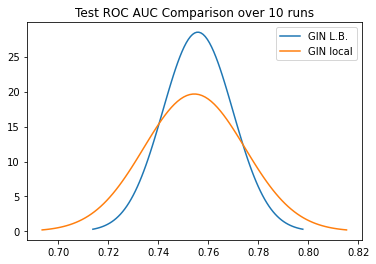

In [225]:
# This comparison only makes sense if using ~100 epochs during training
norm_plot([
    (test_auc_lb, test_auc_lb_std, "GIN L.B."),
    (0.7544, 0.0203, 'GIN local'),
], 'Test ROC AUC Comparison over 10 runs')

In my experiments, I observe an average performance that approximately matches the leaderboard's, but with a standard deviation that's about 50% larger.  

# Improvements with Virtual Nodes

One architecture change that's common to see on the leaderboard for graph classification tasks are the inclusion of "virtual nodes", which seem to be first described in the [Neural message passing for quantum chemistry](https://arxiv.org/abs/1704.01212) paper.  For a given graph in the batch, the idea is to add a new node that shares a connection with all other nodes.  This creates an information pathway during message passing for node pairs that might be large distances from one another in the original graph.  If long-range information is important, which is likely to be the case with molecules modeled as graphs, then this may provide an alternative to e.g., building deep GNNs.

One way to implement virtual nodes might be to modify each graph to add a new node that's fully connected, which would allow us to leverage built-in message passing functionality.  This is complicated, however, because these virtual nodes/edges do not have features like the normal nodes and edges in the graphs.  We choose here to not modify the topology of the underlying graphs and instead implement the message passing operations manually.  This will consist of two separate steps: 1) add the messages from the virtual nodes to each node in the graphs and 2) update the virtual nodes by adding in messages from all the other nodes in the graph.  

## Messages *from* the virtual nodes

Adding messages from the virtual nodes is made more complicated because we need to keep the computations separate for each component graph in the "super-graph".  We don't want to send messages from one graph in the batch to another, for example.  One other nuance is that we'll use a _shared virtual node embedding_ that represents the input features of the virtual node and is the same for all graphs in the dataset.  We will duplicate these virtual node parameters so every graph in the batch has its own copy.  

When we send messages to the nodes we will need to convert from a graph-level tensor, where each row corresponds to a graph in the minibatch, to a nodel-level one.  To do this we will duplicate each graph's copy of the virtual node embedding for each of its nodes.  As an example, if we have two graphs in the batch which have 3 and 4 nodes, respectively, we'll first get: `h_virt_graph = [h_virt_g1, h_virt_g2]`, which creates two copies of the embedding for each graph in the batch.  We then transform that into a node-level representation like: `h_virt_node = [h_virt_g1, h_virt_g1, h_virt_g1, h_virt_g2, h_virt_g2, h_virt_g2, h_virt_g2]`, where each graph's copy is duplicated for every node it contains.  

The reason we do this is it allows us to easily add the message from the correct virtual node to each of the nodes in the "super-graph".  Consider the following.  Let's say we have calculated the "normal" message passing result, where we have ignored the idea of virtual nodes:  `h_mp_normal = g.update_all(fn.copy('x', 'm'), fn.sum('m', 'h'))`.  This result would have a row for every node where the value represents the sum of all the messages in that node's neighborhood.  We can then simply add the message of the virtual node corresponding to the correct graph by: `h_mp_total = h_mp_normal + h_virt_node`, since `h_virt_node` has already taken care of duplicating the correct graph-level copy of the virtual node.  This will give the same result as if each graph had a copy of the virtual node in its graph structure during message passing.

## Messages *to* the virtual nodes

To update the representations of the virtual nodes throughout the GNN layers we also need to send messages from the nodes in the graphs back to the virtual nodes.  This is the reason each graph needs its own copy of the virtual node embedding, as each update to a virtual node should only contain messages from a single component graph.  We will implement this by operating on `h_virt_graph`, which has the graph-level copies of the virtual node embedding.  We will update these embeddings for a given GNN layer by:

1. Summing the current representations of all the nodes in a component graph
2. Adding that result to the graph's virtual node embedding
3. Passing that result through an MLP that's shared across all virtual nodes

Steps 1-2 represent the message passing operation for the virtual nodes.  The only challenge here is in collapsing the tensor of node representations back into graph-level ones, since we only want to sum the node embeddings coming from the same component graph.  We can use DGL's built-in [read-out](https://docs.dgl.ai/api/python/dgl.html#batching-and-reading-out-ops) functions for managing this complexity (e.g., `dgl.sum_nodes`).

In [194]:
class NodeGNNVirtual(nn.Module):
    def __init__(self, emb_dim, num_layers, dropout):
        
        super(NodeGNNVirtual, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.virtualnode_mlps = nn.ModuleList()
        
        self.atom_encoder = AtomEncoder(emb_dim)
        self.bond_encoder = BondEncoder(emb_dim)
        self.virtualnode_embed = nn.Embedding(1, emb_dim)
        
        
        for layer in range(num_layers):
            self.convs.append(GINLayer(emb_dim))
            self.batch_norms.append(nn.BatchNorm1d(emb_dim))
            
            if layer < self.num_layers-1:
                self.virtualnode_mlps.append(nn.Sequential(
                    nn.Linear(emb_dim, 2*emb_dim), 
                    nn.BatchNorm1d(2*emb_dim), 
                    nn.ReLU(), 
                    nn.Linear(2*emb_dim, emb_dim), 
                    nn.BatchNorm1d(emb_dim), 
                    nn.ReLU()
                ))
            
        self.reset_parameters()
    
    def reset_parameters(self):
        # Atom embeddings
        for emb in self.atom_encoder.atom_embedding_list:
            nn.init.xavier_uniform_(emb.weight.data)
        # Bond embeddings
        for emb in self.bond_encoder.bond_embedding_list:
            nn.init.xavier_uniform_(emb.weight.data)
        # Virtual node embedding
        nn.init.constant_(self.virtualnode_embed.weight, 0)
        
        for conv in self.convs:
            conv.reset_parameters()
        
        for bn in self.batch_norms:
            bn.reset_parameters()
    
    def forward(self, g):
        h = self.atom_encoder(g.ndata['feat'])
        edge_embedding = self.bond_encoder(g.edata['feat'])
        
        # Get a copy of the virtual node embedding for each graph in the batch
        h_virt_graph = self.virtualnode_embed(
            th.zeros(g.batch_size).long().to(h.device)
        )
        
        """
        To add the message of the virtual node to every other node in the graph, we 
        need to duplicate each graph's copy of the virtual node embedding for every node 
        in that graph.  To do this, get an indicator for which graph each node belongs to.
        E.g., if batch has 2 graphs and number of nodes for each graph is [2, 3], 
        get something like node_idx = [0, 0, 1, 1, 1].
        
        This will allow us to duplicate the graph-level copies of the virtual node
        embedding, h_virt_graph, via: 
            h_virt_node = h_virt_graph[node_idx]
        
        The `dgl.broadcast_nodes` function may be helpful
        """
        # TODO: get the node_idx tensor
        # Beware: if using GPU, might need to call ".to(h.device)" on 
        # tensors to move them to the correct device
        node_idx = None
        
        for layer in range(self.num_layers):
            # Convert from graph-level to node-level by making duplicates 
            # for each node in each graph
            h_virt_node = h_virt_graph[node_idx]
            
            
            # TODO: loop through the GIN and BatchNorm layers using same flow
            # as NodeGNN (no ReLU on last layer), but include h_virt_node as 
            # an argument to the GIN layers.
            
                
            # Update virtual node for next layer
            if layer < self.num_layers - 1:
                
                with g.local_scope():
                    # TODO: message passing (with self loop) for virtual nodes
                    # Use a sum readout op to add a graph's node embeddings to h_virt_graph
                    # E.g., virtual_mp = h_virt_graph + sum(h_j in G)
                    virtual_mp = None
                
                # transform representation with MLP
                h_virt_graph = F.dropout(
                    self.virtualnode_mlps[layer](virtual_mp), 
                    self.dropout, 
                    training = self.training
                )
        
        return h

In [205]:
vn = NodeGNNVirtual(emb_dim, num_layers, dropout)
vn

NodeGNNVirtual(
  (convs): ModuleList(
    (0): GINLayer(
      (eps): nn.Parameter
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=600, bias=True)
        (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=600, out_features=300, bias=True)
      )
      (bond_encoder): BondEncoder(
        (bond_embedding_list): ModuleList(
          (0): Embedding(5, 300)
          (1): Embedding(6, 300)
          (2): Embedding(2, 300)
        )
      )
    )
    (1): GINLayer(
      (eps): nn.Parameter
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=600, bias=True)
        (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=600, out_features=300, bias=True)
      )
      (bond_encoder): BondEncoder(
        (bond_embedding_list): ModuleList(
          (0): Embedding(5, 300)
 

In [ ]:
# This forward pass should return a tensor without error
vn(batch[0])

In [206]:
model_vn = GraphGNN(emb_dim, num_layers, NodeGNNVirtual, dropout)

In [207]:
assert sum(p.numel() for p in model_vn.parameters()) == 3320706, "Number of GIN + VN parameters doesn't match"

In [ ]:
loggers_vn = repeat_experiments(
    model_vn, train_dataloader, val_dataloader, test_dataloader, 
    device, train_args, N_runs)

Run: 01, Epoch: 76, Loss: 0.0780, Train: 0.9762 AUC, Valid: 0.8198 AUC, Test: 0.7631 AUC
---
Run: 01, Epoch: 77, Loss: 0.0780, Train: 0.9746 AUC, Valid: 0.8023 AUC, Test: 0.7538 AUC
---
Run: 01, Epoch: 78, Loss: 0.0755, Train: 0.9762 AUC, Valid: 0.8363 AUC, Test: 0.7786 AUC
---
Run: 01, Epoch: 79, Loss: 0.0770, Train: 0.9795 AUC, Valid: 0.8295 AUC, Test: 0.7950 AUC
---
Run: 01, Epoch: 80, Loss: 0.0765, Train: 0.9794 AUC, Valid: 0.8417 AUC, Test: 0.8029 AUC
---
Run: 01, Epoch: 81, Loss: 0.0742, Train: 0.9818 AUC, Valid: 0.8323 AUC, Test: 0.7867 AUC
---
Run: 01, Epoch: 82, Loss: 0.0748, Train: 0.9818 AUC, Valid: 0.8247 AUC, Test: 0.7856 AUC
---
Run: 01, Epoch: 83, Loss: 0.0755, Train: 0.9825 AUC, Valid: 0.8287 AUC, Test: 0.7788 AUC
---
Run: 01, Epoch: 84, Loss: 0.0729, Train: 0.9844 AUC, Valid: 0.8274 AUC, Test: 0.8024 AUC
---
Run: 01, Epoch: 85, Loss: 0.0739, Train: 0.9806 AUC, Valid: 0.8322 AUC, Test: 0.7845 AUC
---
Run: 01, Epoch: 86, Loss: 0.0720, Train: 0.9840 AUC, Valid: 0.8098 AUC

In [213]:
# Final performance
loggers_vn.print_statistics()

All runs:
Highest Train: 98.50 ± 0.38
Highest Valid: 83.69 ± 0.77
  Final Train: 91.14 ± 3.59
   Final Test: 76.81 ± 1.63


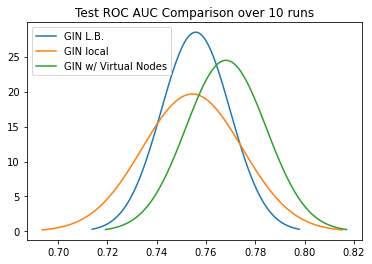

In [226]:
# This comparison only makes sense if using ~100 epochs during training
norm_plot([
    (test_auc_lb, test_auc_lb_std, "GIN L.B."),
    (0.7544, 0.0203, 'GIN local'),
    (0.7681, 0.0163, 'GIN w/ Virtual Nodes'),
], 'Test ROC AUC Comparison over 10 runs')

My experiments show a 2% relative performance improvement and a similar variance compared to the experiments without virtual nodes.  Although this is in line with the Leaderboard, these numbers do not provide a statistically significant result showing an improvement over the baseline.

# Extra Credit
In general, it's a great use of time to find a submission on the leaderboard that's interesting and figure out how to implement it.  Here are two possible avenues for additional exploration:

1. Graph Norm is a method for normalizing node representations for each graph and is designed as a GNN-specific normalization method to help convergence and generalization.  Here are the [paper](https://arxiv.org/abs/2009.03294) and [code](https://github.com/lsj2408/GraphNorm/blob/master/GraphNorm_ws/ogbg_ws/src/dgl_model/norm.py).
2. Free Large-scale Adversarial Augmentation on Graphs (FLAG) is a method for adding adversarial perturbations to the training node features to improve generalization.  Here are the [paper](https://arxiv.org/abs/2010.09891) and [code](https://github.com/devnkong/FLAG). 